# import libraries

In [ ]:
import pandas as pd
import numpy as np
import copy
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import sys
#import category_encoders as ce
import re
#import joblib

#from cx_Oracle import makedsn
#from cx_Oracle import connect



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report
sns.set_style("darkgrid")
#np.set_printoptions(threshold=sys.maxsize)



import pickle
import glob
import random
import numpy as np
import os.path as op


import time
import pdb

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import OrdinalEncoder

from datetime import datetime
import os
import math

In [ ]:

def get_default_device():
  '''Pick GPU if available, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()

def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  '''Wrap a dataloader to move data to a device'''
  def __init__(self, dl, device):
    self.dl=dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''

    return len(self.dl)

    

In [ ]:
# import os

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

# get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/full_test.txt"

'/content/drive/My Drive/Colab Notebooks/full_test.txt'


In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/full_train.txt', 'r') as f:
    reviews_train = f.read()
    
with open('/content/drive/My Drive/Colab Notebooks/full_test.txt', 'r') as f:
    reviews_test = f.read()

# data preprocessing

In [ ]:
reviews_train = reviews_train.lower()
reviews_test = reviews_test.lower()

In [ ]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:

reviews_train_clean = ''.join([c for c in reviews_train if c not in punctuation])
reviews_test_clean = ''.join([c for c in reviews_test if c not in punctuation])

In [ ]:
reviews_train_split = reviews_train_clean.split('\n')
print ('Number of train reviews :', len(reviews_train_split))

reviews_test_split = reviews_test_clean.split('\n')
print ('Number of test reviews :', len(reviews_test_split))

Number of train reviews : 25001
Number of test reviews : 25001


In [ ]:
from collections import Counter

train_text = ' '.join(reviews_train_split)
test_text = ' '.join(reviews_test_split)
# create a list of words
words_train = train_text.split()
words_test = test_text.split()
words = words_train + words_test
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
print(total_words)
sorted_words = count_words.most_common(total_words)

11512912


In [ ]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [ ]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

[=====================================-------------] 74.2% 1234.5/1662.8MB downloaded

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/google_news_word_2_vec', 'wb') as f:
    pickle.dump(wv_from_bin, f)

In [ ]:
embed_size = len(wv_from_bin.word_vec('the'))
embeddings_matrix = [np.zeros((1, embed_size))]
#word_2_int = {'<pad>':0}


vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
vocab_to_int['<pad>'] = 0
list_unknown_words = []

#pdb.set_trace()

for word in vocab_to_int.keys():
    #word_2_int[word] = len(word_2_int)
    if word in wv_from_bin.vocab.keys():
        
        #embeddings_matrix = np.concatenate((embeddings_matrix, wv_from_bin.word_vec(word).reshape(1,-1)), axis = 0)
        embeddings_matrix.append(wv_from_bin.word_vec(word).reshape(1,-1))
        
    else:
        
        list_unknown_words.append(word)
        #embeddings_matrix = np.concatenate((embeddings_matrix, (np.random.rand(1, embed_size) - 0.5) / embed_size), axis = 0)
        embeddings_matrix.append((np.random.rand(1, embed_size) - 0.5) / embed_size)
print(len(list_unknown_words))

120841


In [ ]:
embeddings_matrix = np.asarray(embeddings_matrix)

In [ ]:
embeddings_matrix = np.squeeze(embeddings_matrix)

In [ ]:
reviews_train_int = []
for review in reviews_train_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_train_int.append(r)
    
reviews_test_int = []
for review in reviews_test_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_test_int.append(r)
    
#print (reviews_train_int[0:3])

In [ ]:
reviews_train_len = [len(x) for x in reviews_train_int]
reviews_test_len = [len(x) for x in reviews_test_int]

In [ ]:
encoded_train_labels = [1 if i < 12500 else 0 for i in range(25000)]
encoded_test_labels = [1 if i < 12500 else 0 for i in range(25000)]

In [ ]:
reviews_train_int = [ reviews_train_int[i] for i, l in enumerate(reviews_train_len) if l>0 ]
encoded_train_labels = [encoded_train_labels[i] for i, l in enumerate(reviews_train_len) if l> 0 ]

reviews_test_int = [ reviews_test_int[i] for i, l in enumerate(reviews_test_len) if l>0 ]
encoded_test_labels = [encoded_test_labels[i] for i, l in enumerate(reviews_test_len) if l> 0 ]

In [ ]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [ ]:
features_train = pad_features(reviews_train_int, 200)
features_test = pad_features(reviews_test_int, 200)

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(
    np.asarray(features_train), np.asarray(encoded_train_labels), test_size=0.25, random_state=123)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


# data visualization of outputs

# set up embedding class

In [ ]:
class ModelEmbeddings(nn.Module): 
    """
    Class that converts input words to their embeddings.
    
    """
    def __init__(self, embed_size, vocab, pad_token_idx, pre_trained_matrix):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        # default values
        self.source = None
        #self.target = None

        #src_pad_token_idx = vocab.src['<pad>']
        #tgt_pad_token_idx = vocab.tgt['<pad>']

        ### YOUR CODE HERE (~2 Lines)
        ### TODO - Initialize the following variables:
        ###     self.source (Embedding Layer for source language)
        ###     self.target (Embedding Layer for target langauge)
        ###
        ### Note:
        ###     1. `vocab` object contains two vocabularies:
        ###            `vocab.src` for source
        ###            `vocab.tgt` for target
        ###     2. You can get the length of a specific vocabulary by running:
        ###             `len(vocab.<specific_vocabulary>)`
        ###     3. Remember to include the padding token for the specific vocabulary
        ###        when creating your Embedding.
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
        '''
        self.source = nn.Embedding(len(vocab), self.embed_size, padding_idx=pad_token_idx)
        embeds = torch.from_numpy(pre_trained_matrix)
        self.source.weight = embeds
        '''
        
        pre_trained_tensor = torch.from_numpy(pre_trained_matrix).to(torch.float64)
        self.source = nn.Embedding(pre_trained_tensor.size(0), pre_trained_tensor.size(1), padding_idx=pad_token_idx)
        self.source.weight = nn.Parameter(pre_trained_tensor)
        
        #weight = torch.from_numpy(pre_trained_matrix).to(torch.float64)
        #self.source = nn.Embedding.from_pretrained(weight)
        
        ### END YOUR CODE

# set up Neural Architecture

In [ ]:
# Here we define our model as a class
class NeuralNet(nn.Module):

    def __init__(self, embed_size, hidden_dim, batch_size, vocab, pad_token_idx, pre_trained_matrix, num_layers=1,
                 output_dim=1, dropout_rate=0.2):
        super(NeuralNet, self).__init__()
        self.embed_size = embed_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.model_embeddings = ModelEmbeddings(embed_size, vocab, pad_token_idx, pre_trained_matrix)
        
        #define dropout layer
        self.dropout = nn.Dropout(dropout_rate, inplace = False)
        # Define the LSTM layer
        
        
        self.lstm_layer = nn.LSTM(input_size=embed_size, hidden_size=hidden_dim, dropout=dropout_rate, bidirectional=True)
        
        # define projection layers
        self.att_proj_layer = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim, bias=False)
        self.h_projection = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim, bias=False)
        
        
        self.combined_output_projection = nn.Linear(in_features=hidden_dim*3, out_features=output_dim)
        # Define the output layer
        #self.linear_layer = nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=False)
        
        '''
        def init_hidden(self):
            # This is what we'll initialise our hidden state as
            return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                    torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        '''
    
    
    
    def generate_sent_masks(self, enc_hiddens, source_lengths):
        """ Generate sentence masks for encoder hidden states.

        @param enc_hiddens (Tensor): encodings of shape (b, src_len, 2*h), where b = batch size,
                                     src_len = max source length, h = hidden size. 
        @param source_lengths (List[int]): List of actual lengths for each of the sentences in the batch.

        @returns enc_masks (Tensor): Tensor of sentence masks of shape (b, src_len),
                                    where src_len = max source length, h = hidden size.
        """
        #pdb.set_trace()
        enc_masks = torch.zeros(enc_hiddens.size(0), enc_hiddens.size(1), dtype=torch.float).to(device)
        for e_id, src_len in enumerate(source_lengths):
            enc_masks[e_id, src_len:] = 1
        return enc_masks
    
    def forward(self, source_padded, source_lengths):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        '''
        pad_embs = F.embedding(source_padded, self.model_embeddings.source.weight)
        pack_embs = nn.utils.rnn.pack_padded_sequence(pad_embs, source_lengths, batch_first=False)
        enc_hiddens_pack, (last_hidden, last_cell) = self.lstm(pack_embs)
        enc_hiddens_pad = 
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        ''' 
        #pdb.set_trace()
        pad_embs = F.embedding(source_padded, self.model_embeddings.source.weight)
        pack_embs = nn.utils.rnn.pack_padded_sequence(pad_embs, source_lengths, batch_first=False, enforce_sorted=False)
        
        enc_hiddens_pack, (last_hidden, last_cell) = self.lstm_layer(pack_embs.float())
        
        h_cat = torch.cat((last_hidden[0], last_hidden[1]), 1)
        
        init_h = self.h_projection(h_cat)
        
        #pdb.set_trace()
        enc_hiddens_pad = nn.utils.rnn.pad_packed_sequence(enc_hiddens_pack, batch_first=True, total_length=source_padded.size(0))
        enc_hiddens = enc_hiddens_pad[0]
        #pdb.set_trace()
        #create mask of paddings
        enc_masks = self.generate_sent_masks(enc_hiddens, source_lengths)
        
        #apply attention proj
        enc_hiddens_proj = self.att_proj_layer(enc_hiddens)
        
        #appy attention
        #multi_e_t = torch.bmm(enc_hiddens_proj, last_hidden.permute(1,2,0), out=None)
        multi_e_t = torch.bmm(enc_hiddens_proj, init_h.unsqueeze(2), out=None)
        e_t = multi_e_t.squeeze()
        
        #set e_t to -inf where enc_masks has 1
        if enc_masks is not None:
            e_t.data.masked_fill_(enc_masks.bool(), -float('inf'))
        
        m = nn.Softmax(dim=1)
        alpha_t = m(e_t)
        a_t = torch.bmm(enc_hiddens.permute(0, 2, 1), alpha_t.unsqueeze(2)).squeeze()
        #U_t = torch.cat((a_t, last_hidden.squeeze()), 1)
        U_t = torch.cat((a_t, init_h.squeeze()), 1)
        V_t = self.combined_output_projection(U_t)
        O_t = self.dropout(torch.tanh(V_t))
        
        
        #use the hidden forward and backward states from the last time step
        #for the future could implement attention instead
        
        #pdb.set_trace()
        #h_cat = torch.cat((last_hidden[0], last_hidden[1]), 1)
        
        
        
        #h_d = self.dropout(h_cat)
        
#         h_d = self.dropout(last_hidden)

#         y_pred = self.linear_layer(h_d)
        
#         y_pred = torch.squeeze(y_pred)
        #pdb.set_trace()
        #m = nn.Softmax(dim=1)
        #O_t = m(O_t)
        return O_t

# train model

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        



def create_minibatches(X, y, batch_size): 
    #pdb.set_trace()
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
    #pdb.set_trace()
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    #pdb.set_trace()
    return mini_batches 





def train(startTime, model, x, y, X_test, y_test, output_path, data_set, batch_size=32, n_epochs=10, lr=0.0001):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()
    #loss_func = torch.nn.BCELoss()
    loss_train_vec = []
    loss_test_vec = []
    
    
    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch+1,n_epochs))
        result = train_for_epoch(model, x, y, optimizer, loss_func, data_set, batch_size, epoch)
        
        if epoch == 0:
            best_result = result
        
        if result <= best_result:
            best_result = result
            print("New best result! Saving model.")
            torch.save(model.state_dict(), output_path)
         
            
        # model.eval()
        
        # src_len_test = []
        # for failures in X_test:
        #     src_len_test.append(sum(failures == data_set["<pad>"]))
        # src_len_test = np.asarray([src_len_test], dtype=int)
        # src_len_test = X_test.shape[1] - src_len_test
        # src_len_test = torch.from_numpy(src_len_test).to(torch.int64)
        # src_len_test = torch.squeeze(src_len_test)

        # test_x = torch.from_numpy(X_test).to(int)
        # test_x = torch.t(test_x)
        
        # test_y = torch.squeeze(torch.from_numpy(y_test).long())
        # print(80* "=")
        # print("getting output from the model")
        # final_out = model(test_x.to(device), src_len_test.to(device))
        # print(80* "=")
        # loss = torch.nn.CrossEntropyLoss()
        # test_loss = loss(final_out.to(device), test_y.to(device))
        # print("test loss:{}".format(test_loss))
        
        # print("time elapsed %d seconds" % (time.time() - startTime))
        # loss_test_vec.append(test_loss.cpu().data.numpy())
        # loss_train_vec.append(result)
    
    return loss_train_vec, loss_test_vec
        

def train_for_epoch(model, x, y, optimizer, loss_func, data_set, batch_size, epoch):
    model.train()
    n_minibatches = math.floor(len(x) / batch_size)
    #pdb.set_trace()
    loss_meter = AverageMeter()
    #accuracy_meter = AverageMeter()
    batch = 1
    print_every = 10
    num_examples = 0
    for row in create_minibatches(x, y, batch_size):
        optimizer.zero_grad()
        loss = 0
        
        #train_x = torch.from_numpy(row[0]).float()
        train_x_np = row[0]
        train_y = torch.squeeze(torch.from_numpy(row[1]).long())
        #train_y = torch.from_numpy(row[1]).long()
        #train_y = torch.from_numpy(row[1]).long()
        
        #source_lengths = []
        
        #for failures in train_x_np:
            #source_lengths.append(sum(failures == -2))
            
        source_lengths = [sum(failures == data_set["<pad>"]) for failures in train_x_np]
        source_lengths = np.asarray([source_lengths], dtype=int)
        source_lengths = train_x_np.shape[1] - source_lengths
        source_lengths = torch.from_numpy(source_lengths).to(torch.int64)
        source_lengths = torch.squeeze(source_lengths)
        
        
        train_x = torch.from_numpy(row[0]).to(int)
        train_x = torch.t(train_x)

        #pdb.set_trace()
        #output = model(DeviceDataLoader(train_x, device), DeviceDataLoader(source_lengths, device))
        output = model(train_x.to(device), source_lengths.to(device))
        #pdb.set_trace()
        #loss = loss_func(DeviceDataLoader(output, device), DeviceDataLoader(train_y, device))
        loss = loss_func(output.to(device), train_y.to(device))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        
        optimizer.step()
        
        loss_meter.update(loss.item())
        #print(batch)
        num_examples+=train_x.size(1)
        if batch % print_every == 0:
#             print("Epoch:",epoch+1, ", iter:", batch, ", loss:", loss.detach().numpy(), ", cum_examples:",
#                   num_examples,',', round((batch/n_minibatches)*100), '% Completed')
            print("Epoch:{:d}, iter:{:d}, loss:{:.5f}, cum_examples:{:d}, {:.2f}% Completed ".format(epoch+1, batch,loss.cpu().detach().numpy(),num_examples,
                                               (batch/n_minibatches)*100))
#             print("Epoch:{}, iter:{}, loss:{}, cum_examples:{}, {}% Completed ".format(epoch+1, batch,loss.detach().numpy,num_examples,
#                                            (batch/n_minibatches)*100))
        batch += 1
        
       
    print ("Average Train Loss: {}".format(loss_meter.avg))
    #print ("Average Accuracy Loss: {}".format(accuracy_meter.avg))
    
    return loss_meter.avg

# run model

In [ ]:



model = NeuralNet(embed_size=embed_size, hidden_dim=200, batch_size=64, vocab=vocab_to_int,
                  pad_token_idx=vocab_to_int["<pad>"], pre_trained_matrix=embeddings_matrix, num_layers=1,
                  output_dim=2, dropout_rate=0.2)

to_device(model, device)


output_dir = "/content/drive/My Drive/Colab Notebooks/results/{:%Y%m%d_%H%M%S}".format(datetime.now())
output_path = output_dir + "model.weights"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

startTime=time.time()

train_loss, test_loss = train(startTime, model, X_train, y_train, X_test, y_test, output_path, vocab_to_int, model.batch_size
                              ,n_epochs=10, lr=0.0001)

print("training took %d seconds" % (time.time() - startTime))

# print(80* "=")
# print("TESTING")
# print(80* "=")
# print("Restoring the best model wieghts found on the set")
# model.load_state_dict(torch.load(output_path))
# print("Final evation on the test set: ")
# model.eval()



# final_out = model(torch.from_numpy(X_test).float())
# final_test = torch.from_numpy(y_test).float()
# loss = torch.nn.CrossEntropyLoss()
# final_loss = loss(final_out, final_test)
# print('Cross Entropy Loss: ',final_loss.detach().numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 out of 10
Epoch:1, iter:10, loss:0.70546, cum_examples:640, 3.42% Completed 
Epoch:1, iter:20, loss:0.69566, cum_examples:1280, 6.85% Completed 
Epoch:1, iter:30, loss:0.69318, cum_examples:1920, 10.27% Completed 
Epoch:1, iter:40, loss:0.69012, cum_examples:2560, 13.70% Completed 
Epoch:1, iter:50, loss:0.69279, cum_examples:3200, 17.12% Completed 
Epoch:1, iter:60, loss:0.68840, cum_examples:3840, 20.55% Completed 
Epoch:1, iter:70, loss:0.68919, cum_examples:4480, 23.97% Completed 
Epoch:1, iter:80, loss:0.68800, cum_examples:5120, 27.40% Completed 
Epoch:1, iter:90, loss:0.68934, cum_examples:5760, 30.82% Completed 
Epoch:1, iter:100, loss:0.68819, cum_examples:6400, 34.25% Completed 
Epoch:1, iter:110, loss:0.68469, cum_examples:7040, 37.67% Completed 
Epoch:1, iter:120, loss:0.68112, cum_examples:7680, 41.10% Completed 
Epoch:1, iter:130, loss:0.66920, cum_examples:8320, 44.52% Completed 
Epoch:1, iter:140, loss:0.65155, cum_examples:8960, 47.95% Completed 
Epoch:1, iter:

In [ ]:
print(train_loss)
#print(test_loss)

[]


In [ ]:
epochs = np.linspace(1,10,num=10)

ValueError: ignored

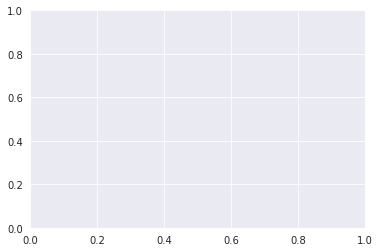

In [ ]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot( epochs, train_loss, color='green');
#ax.plot( epochs, test_loss, color='red');
ax.legend(['train', 'validation'])

# testing

In [ ]:
print(80 * "=")
print("TESTING")
print(80 * "=")
print("Restoring the best model wieghts found on the set")
#output_path = "results/20191205_214527model.weights"
model.load_state_dict(torch.load(output_path))
print("Final evation on the test set: ")
to_device(model, device='cpu')
model.eval()



src_len_test = []

for failures in X_test:
    src_len_test.append(sum(failures == vocab_to_int["<pad>"]))

src_len_test = np.asarray([src_len_test], dtype=int)
src_len_test = X_test.shape[1] - src_len_test

src_len_test = torch.from_numpy(src_len_test).to(torch.int64)
src_len_test = torch.squeeze(src_len_test)

test_x = torch.from_numpy(X_test).to(int)

test_x = torch.t(test_x)

test_y = torch.squeeze(torch.from_numpy(y_test).long())
print(80 * "=")
print("getting output from the model")
final_out = model(test_x, src_len_test)
print(80 * "=")
# final_test = torch.from_numpy(y_test).float()
loss = torch.nn.CrossEntropyLoss()
final_loss = loss(final_out, test_y)

m = nn.Softmax(dim=1)
print('Test Cross Entropy Loss: ', final_loss.detach().numpy())
print('Test Accuracy: {:f}'.format(metrics.accuracy_score(y_test, torch.argmax(m(final_out), dim=1).data.numpy())))

# top_vec_test = torch.topk(m(final_out), 5, dim = 1)[1].data.numpy()

# #eval_vec = np.zeros(len(out))
# eval_list_test = []

# for real, top in zip(test_y.data.numpy(), top_vec_test):
#     #pdb.set_trace()
#     #np.concatenate((eval_vec, (np.isin(real, top3))), axis = 0)
#     eval_list_test.append(np.isin(real, top))


# #pdb.set_trace()
# print("Test Accuracy for top 5 {}".format(sum(eval_list_test)/len(eval_list_test)))
print(classification_report(y_test, torch.argmax(m(final_out), dim=1).data.numpy().reshape(-1, 1)))

TESTING
Restoring the best model wieghts found on the set
Final evation on the test set: 
getting output from the model


# test metrics

In [ ]:
# model = NeuralNet(embed_size=10, hidden_dim=200, batch_size=128, vocab=data_set.mapping,
#                   pad_token_idx=data_set.mapping["<pad>"], pre_trained_matrix=failure_text_embeddings, num_layers=1,
#                   output_dim=len(encoder.categories_[0]), dropout_rate=0.2)




print(80* "=")
print("TESTING")
print(80* "=")
print("Restoring the best model wieghts found on the set")
#output_path = "results/20191114_145657model.weights"
model.load_state_dict(torch.load(output_path))
print("Final evation on the test set: ")
model.eval()


src_len_test = []

for failures in X_test:
    src_len_test.append(sum(failures == data_set.mapping["<pad>"]))

src_len_test = np.asarray([src_len_test], dtype=int)
src_len_test = X_test.shape[1] - src_len_test


src_len_test = torch.from_numpy(src_len_test).to(torch.int64)
src_len_test = torch.squeeze(src_len_test)

test_x = torch.from_numpy(X_test).to(int)

test_x = torch.t(test_x)

test_y = torch.squeeze(torch.from_numpy(y_test).long())
print(80* "=")
print("getting output from the model")
final_out = model(test_x, src_len_test)
print(80* "=")
#final_test = torch.from_numpy(y_test).float()
loss = torch.nn.CrossEntropyLoss()
final_loss = loss(final_out, test_y)


m = nn.Softmax(dim=1)
print('Test Cross Entropy Loss: ',final_loss.detach().numpy())
print('Test Accuracy: {:f}'.format(metrics.accuracy_score(y_test, torch.argmax(m(final_out), dim=1).data.numpy())))



# top_vec_test = torch.topk(m(final_out), 5, dim = 1)[1].data.numpy()

# #eval_vec = np.zeros(len(out))
# eval_list_test = []

# for real, top in zip(test_y.data.numpy(), top_vec_test):
#     #pdb.set_trace()
#     #np.concatenate((eval_vec, (np.isin(real, top3))), axis = 0)
#     eval_list_test.append(np.isin(real, top))

    
# #pdb.set_trace()
# print("Test Accuracy for top 5 {}".format(sum(eval_list_test)/len(eval_list_test)))
print(classification_report(y_test, torch.argmax(m(final_out), dim=1).data.numpy().reshape(-1,1)))

TESTING
Restoring the best model wieghts found on the set


RuntimeError: unexpected EOF, expected 436048800 more bytes. The file might be corrupted.

In [ ]:
diff_test = np.absolute(torch.argmax(m(final_out), dim=1).data.numpy().reshape(-1,1) - y_test)
y_test_incorrect = y_test[diff_test != 0]
y_test_correct = y_test[diff_test == 0]

In [ ]:
test_vals_err = pd.DataFrame(y_test_incorrect, columns=['y_test_incorrect'])
te = test_vals_err['y_test_incorrect'].value_counts()
print(te)
print(te/test_vals_err.shape[0])

In [ ]:
test_vals_corr = pd.DataFrame(y_test_correct, columns=['y_test_correct'])
tc = test_vals_corr['y_test_correct'].value_counts()
print(tc)
print(tc/test_vals_corr.shape[0])

In [ ]:
np.concatenate((encoder.transform(encoder.categories_[0].reshape(-1,1)), encoder.categories_[0].reshape(-1,1)), axis=1)

In [ ]:
print(counts_T)
print(counts_T/data['T'].shape[0])

In [ ]:
print(classification_report(y_test, torch.argmax(m(final_out), dim=1).data.numpy().reshape(-1,1)))

In [ ]:
m = nn.Softmax(dim=1)
print('Test Cross Entropy Loss: ',final_loss.detach().numpy())
print('Test Accuracy: {:f}'.format(metrics.accuracy_score(y_test, torch.argmax(m(final_out), dim=1).data.numpy())))



top_vec_test = torch.topk(m(final_out), 5, dim = 1)[1].data.numpy()

#eval_vec = np.zeros(len(out))
eval_list_test = []

for real, top in zip(test_y.data.numpy(), top_vec_test):
    #pdb.set_trace()
    #np.concatenate((eval_vec, (np.isin(real, top3))), axis = 0)
    eval_list_test.append(np.isin(real, top))

    
#pdb.set_trace()
print("Test Accuracy for top 5 {}".format(sum(eval_list_test)/len(eval_list_test)))

In [ ]:
top_vec_test = torch.topk(m(final_out), 3, dim = 1)[1].data.numpy()

#eval_vec = np.zeros(len(out))
eval_list_test = []

for real, top in zip(train_y.data.numpy(), top_vec_test):
    #pdb.set_trace()
    #np.concatenate((eval_vec, (np.isin(real, top3))), axis = 0)
    eval_list_test.append(np.isin(real, top))
    


    
#pdb.set_trace()
print("Test Accuracy for top 3 {}".format(sum(eval_list_test)/len(eval_list_test)))

In [ ]:
top_vals = torch.argmax(m(final_out), dim=1).data.numpy()
test_list = []
for actual, top_test in zip(train_y.data.numpy(), top_vals):
    test_list.append(np.isin(actual, top_test))

print("Test Accuracy for top 1 {}".format(sum(test_list)/len(test_list)))
metrics.accuracy_score(y_test, top_vals)

In [ ]:
y_test.shape

In [ ]:
top_vals.reshape(-1,1).shape

In [ ]:
m = nn.Softmax(dim=1)

print('Test Accuracy: {:f}'.format(metrics.accuracy_score(y_test, torch.argmax(m(final_out), dim=1).data.numpy())))


top_vec_test = torch.topk(m(final_out), 5, dim = 1)[1].data.numpy()

#eval_vec = np.zeros(len(out))
eval_list_test = []

for real, top in zip(test_y.data.numpy(), top_vec_test):
    #pdb.set_trace()
    #np.concatenate((eval_vec, (np.isin(real, top3))), axis = 0)
    eval_list_test.append(np.isin(real, top))

    
#pdb.set_trace()
print("Test Accuracy for top 5 {}".format(sum(eval_list_test)/len(eval_list_test)))

# train metrics

In [ ]:
train_x_np = X_train
train_y = torch.squeeze(torch.from_numpy(y_train).long())


source_lengths = [sum(failures == data_set.mapping["<pad>"]) for failures in train_x_np]
source_lengths = np.asarray([source_lengths], dtype=int)
source_lengths = train_x_np.shape[1] - source_lengths
source_lengths = torch.from_numpy(source_lengths).to(torch.int64)
source_lengths = torch.squeeze(source_lengths)


train_x = torch.from_numpy(train_x_np).to(torch.int64)
train_x = torch.t(train_x)

out_train = model(train_x, source_lengths)

top_vec = torch.topk(m(out_train), 2, dim = 1)[1].data.numpy()

#eval_vec = np.zeros(len(out))
eval_list = []

for real_train, top_train in zip(train_y.data.numpy(), top_vec):
    #pdb.set_trace()
    #np.concatenate((eval_vec, (np.isin(real, top3))), axis = 0)
    eval_list.append(np.isin(real_train, top_train))

    
#pdb.set_trace()
print('Train Cross Entropy Loss: ',loss(out_train, train_y).detach().numpy())
print('Train Accuracy: {:f}'.format(metrics.accuracy_score(y_train, torch.argmax(m(out_train), dim=1).data.numpy())))
print("Train Accuracy for top 2 {}".format(sum(eval_list)/len(eval_list)))

In [ ]:
print('Train Cross Entropy Loss: ',loss(out_train, train_y).detach().numpy())
print('Train Accuracy: {:f}'.format(metrics.accuracy_score(y_train, torch.argmax(m(out_train), dim=1).data.numpy())))
print("Train Accuracy for top 3 {}".format(sum(eval_list)/len(eval_list)))

In [ ]:
final_out[2,:]

In [ ]:
test_y[2:3]

In [ ]:
loss(final_out[2:3,:], test_y[2:3])

In [ ]:
final_out[1,20]

In [ ]:
m = nn.Softmax(dim=1)

m(final_out[2:3,:])

res = np.zeros(114)
res[20] = 1
res

In [ ]:
final_out[2:3,:]

In [ ]:
torch.argmax(m(final_out[0:1, :]))

In [ ]:
m(final_out[0:1, :])

In [ ]:
torch.argmax(m(final_out), dim=1).data.numpy()

In [ ]:
y_test

In [ ]:
metrics.accuracy_score(y_test, torch.argmax(m(final_out), dim=1).data.numpy())

In [ ]:
metrics.accuracy_score(torch.squeeze(torch.from_numpy(test_y).long()), torch.argmax(m(final_out), dim=1).data.numpy())

In [ ]:
classification_report(y_true, y_pred

In [ ]:
failure_text_embeddings.shape

In [ ]:
y_train[0,:]

In [ ]:
encoder.get_params()

In [ ]:
vec = np.array([1,2,3,4,5,-2,-2,-2])

In [ ]:
vec[0:0+1]

In [ ]:
sum(vec == -2)

In [ ]:
new_dict = {"feeling":0,"negative":1}

In [ ]:
new_dict

In [ ]:
new_dict.update({"<pad>":2})